In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
fullDF = pd.read_csv('/home/welling/git/synecoace/data/nsch_2016_topical.csv')
print fullDF.columns

Index([u'FIPSST', u'HHID', u'FORMTYPE', u'TOTKIDS_R', u'HHLANGUAGE',
       u'SC_AGE_YEARS', u'SC_SEX', u'K2Q35A_1_YEARS', u'MOMAGE',
       u'K6Q41R_STILL',
       ...
       u'BIRTHWT', u'CBSAFP_YN', u'FWC', u'CURRINS', u'INSTYPE', u'HOUSE_GEN',
       u'HHSIZE_I', u'HHSIZE_IF', u'FPL_IF', u'INSGAP'],
      dtype='object', length=422)


## The Model ##

Consider two sequential ages, say 6 and 7 years.  Given an child at one age, the goal is to produce a *guide function* which can be used to select a collection of children at the other age which as a group describe the most likely match to the original child.  Specifically, given a sample of individuals at one age, the guide function should generate samples at the other age having the highest possible *mutual information* with the first group.

The guided samples will be selected by applying *Metropolis sampling* using the guide function.  This requires only that the guide function be positive definite and integrable.  In essense the guide function is proportional to the likelihood that a sampled child at one age matches a specific child at the other age.

We will develop an appropriate guide function by defining a function of an appropriate form in terms of a set of weights.  Samples will be drawn based on the given weights, the mutual information will be calculated, and the weights will be updated so as to increase the mutual information.  This process will be repeated until the mutual information is maximized.  The set of weights which produces the maximum mutual information is the optimal choice of weights given the initial choice of form for the guide function.

## Factors we are using ##
* ACE7: experienced violence
* ACE8: drugs and alcohol
* SC_AGE_YEARS: selected child age
* K4Q32X01: vision tested by eye doctor (2.0 -> False)
* K7Q30: sports teams
* K7Q31: clubs or organizations
* FPL: percent of federal poverty level?
* AGEPOS4: birth order
* FWC: sample weight
* YEAR: survey year

In [3]:
subDF=fullDF[['ACE7', 'ACE8', 'FWC', 'YEAR', 'FPL', 'SC_AGE_YEARS','K4Q32X01', 'K7Q30', 'K7Q31', 'AGEPOS4']]
subDF = subDF.dropna()
print len(subDF)
#print subDF

28084


In [4]:
age6DF = subDF[subDF.SC_AGE_YEARS==6]
print len(age6DF)
age7DF = subDF[subDF.SC_AGE_YEARS==7]
print len(age7DF)

1768
1872


Select samples from the table in a weighted fashion

In [5]:
def mkSamps(df, nSamp):
    fracWt = df['FWC']/df['FWC'].sum()
    choices = np.random.choice(len(df), nSamp, p=fracWt)
    return df.iloc[choices].drop(columns=['FWC'])
nSamp = 10
print mkSamps(age6DF, nSamp)


       ACE7  ACE8    YEAR    FPL  SC_AGE_YEARS  K4Q32X01  K7Q30  K7Q31  \
9624    2.0   2.0  2016.0  205.0           6.0       2.0    1.0    1.0   
24340   2.0   2.0  2016.0   60.0           6.0       2.0    1.0    1.0   
39052   2.0   2.0  2016.0  400.0           6.0       2.0    2.0    2.0   
19406   2.0   2.0  2016.0  400.0           6.0       2.0    1.0    1.0   
47453   2.0   2.0  2016.0  195.0           6.0       2.0    2.0    2.0   
34280   2.0   2.0  2016.0  400.0           6.0       2.0    2.0    2.0   
6628    2.0   2.0  2016.0   59.0           6.0       1.0    2.0    2.0   
19256   2.0   2.0  2016.0  187.0           6.0       2.0    1.0    2.0   
22551   2.0   2.0  2016.0  283.0           6.0       2.0    2.0    2.0   
16350   2.0   2.0  2016.0  312.0           6.0       2.0    2.0    2.0   

       AGEPOS4  
9624       2.0  
24340      3.0  
39052      2.0  
19406      2.0  
47453      3.0  
34280      1.0  
6628       1.0  
19256      3.0  
22551      2.0  
16350      2.0 

In [6]:
COLUMN_DICT = {key : idx for idx, key in enumerate(mkSamps(subDF, 1).columns)}
print COLUMN_DICT

{'K4Q32X01': 5, 'FPL': 3, 'K7Q31': 7, 'K7Q30': 6, 'ACE8': 1, 'YEAR': 2, 'AGEPOS4': 8, 'ACE7': 0, 'SC_AGE_YEARS': 4}


FPL needs to be binned to form a histogram to get the quantization we need for this.  Bins of 50 seems OK.

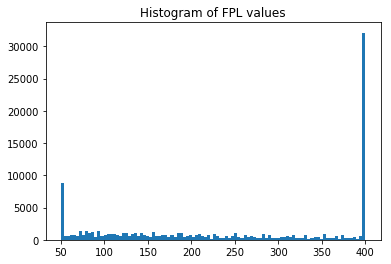

In [7]:
fplSamps = mkSamps(subDF, 100000)['FPL']
plt.hist(fplSamps, bins=100)
plt.title('Histogram of FPL values')
plt.show()

We need to enumerate the possible states for our variables.  Assume fixed age and ignore the ACE components for the moment.  

In [8]:
def whichBin(sampV):
    """
    Input is an ndarray of sample values
    """
    fplBinWidth = 50
    fplMin = 50
    bin = np.abs((sampV[:, COLUMN_DICT['FPL']] - fplMin) // 50).astype('int')
    assert (bin >= 0).all() and (bin < 8).all(), 'FPL out of range?'
    nBins = 8
    # Each of the following is either 1.0 or 2.0
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K4Q32X01']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q30']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q31']] == 1.0)
    nBins *= 2
    return bin, nBins

def scatter(idx, vals, target):
    """target[idx] += vals, but allowing for repeats in idx"""
    np.add.at(target, idx.ravel(), vals.ravel())


In [9]:
def toHisto(sampV):
    """Generate a histogram of sample bins"""
    binV, nBins = whichBin(sampV)
    targ = np.zeros([nBins], dtype=np.int32)
    vals = np.ones([len(sampV)], dtype=np.int32)
    scatter(binV, vals, targ)
    return targ

In [10]:
def toProbV(sampV):
    sampH = toHisto(sampV)
    probV = sampH.astype(np.float64)
    probV /= np.sum(probV)
    return probV

In [11]:
sampV = mkSamps(subDF, 1000)
print sampV.columns
print COLUMN_DICT['FPL']
sampH = toHisto(sampV.values)
print sampH
probV = toProbV(sampV.values)
print probV

Index([u'ACE7', u'ACE8', u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01',
       u'K7Q30', u'K7Q31', u'AGEPOS4'],
      dtype='object')
3
[ 47   9  16  11  52  13  22  36   8  10   8  12  31  17  11  18  25   5
   9  10  18  11  12  21   6   1   5  13  16   5  12  16   7   2   8  11
  12   2   8  11   3   0   1  17   7   7  13  14   6   3   3   7   2   5
   4  17  12  16  31  68  26  22  25 124]
[0.047 0.009 0.016 0.011 0.052 0.013 0.022 0.036 0.008 0.01  0.008 0.012
 0.031 0.017 0.011 0.018 0.025 0.005 0.009 0.01  0.018 0.011 0.012 0.021
 0.006 0.001 0.005 0.013 0.016 0.005 0.012 0.016 0.007 0.002 0.008 0.011
 0.012 0.002 0.008 0.011 0.003 0.    0.001 0.017 0.007 0.007 0.013 0.014
 0.006 0.003 0.003 0.007 0.002 0.005 0.004 0.017 0.012 0.016 0.031 0.068
 0.026 0.022 0.025 0.124]


Given the probV we can calculate mutual information:
$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X} p(x, y) log \left (\frac{p(x,y)}{p(x)p(y)} \right )
$$

In [12]:
def mutualInfo(sampVX, sampVY):
    assert len(sampVX) == len(sampVY), 'Sample vector lengths do not match'
    binVX, nBinsX = whichBin(sampVX)
    binVY, nBinsY = whichBin(sampVY)
    assert nBinsX == nBinsY, 'Unexpectedly got different bin counts?'
    cA = np.zeros([nBinsX, nBinsX], dtype=np.int32)
    idxV = np.ravel_multi_index(np.array([binVX, binVY]), (nBinsX, nBinsX))
    np.add.at(cA.ravel(), idxV, np.ones(len(idxV), dtype=np.int32).ravel())
    pA = cA.astype(np.float32)
    pA /= sum(pA.ravel())
    xPV = toProbV(sampVX)
    yPV = toProbV(sampVY)
    xyPA = np.einsum('i,j->ij', xPV, yPV)  # einsum is my new favorite function
    oldErr = np.seterr(invalid='ignore', divide='ignore')
    prodA = pA * np.nan_to_num(np.log(pA / xyPA))  # element-wise calculation
    np.seterr(**oldErr)
    return np.sum(prodA.ravel())

sampX = mkSamps(subDF, 3000)
sampY = mkSamps(subDF, 3000)
print mutualInfo(sampX.values, sampY.values)
print mutualInfo(sampX.values, sampX.values)
print mutualInfo(sampY.values, sampY.values)

0.5712178158078175
3.788205479578413
3.7778078507964574


In [13]:
########
# This implementation (from stackoverflow) produces the same MI values as the one above
# stackoverflow.com/questions/20491028/optimal-way-to-compute-pairwise-mutual-information-using-numpy
########
#from scipy.stats import chi2_contingency
#
#def calc_MI(x, y, bins):
#    c_xy = np.histogram2d(x, y, bins)[0]
#    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
#    mi = 0.5 * g / c_xy.sum()
#    return mi
#
#def mutualInfo(sampVX, sampVY):
#    assert len(sampVX) == len(sampVY), 'Sample vector lengths do not match'
#    binVX, nBinsX = whichBin(sampVX)
#    binVY, nBinsY = whichBin(sampVY)
#    assert nBinsX == nBinsY, 'Unexpectedly got different bin counts?'
#    return calc_MI(binVX, binVY, nBinsX)
#
#print mutualInfo(sampX.values, sampY.values)
#print mutualInfo(sampX.values, sampX.values)
#print mutualInfo(sampY.values, sampY.values)

Define a scalar function on a pair of samples and a weight vector

In [14]:
wtSer = pd.Series({'YEAR': 1.0,
                   'FPL':1.0e-4,  # because it's percent
                   'SC_AGE_YEARS': 1.0, 
                   'K4Q01': 1.0, 
                   'K4Q32X01': 1.0,
                   'K7Q30':1.0,
                   'K7Q31': 1.0,
                   'AGEPOS4': 1.0}, index=subDF.columns)
wtSer = wtSer.drop(labels=['ACE7', 'ACE8', 'FWC'])  # get the right index order but no extra entries
print wtSer
print wtSer.values
print wtSer.index

YEAR            1.0000
FPL             0.0001
SC_AGE_YEARS    1.0000
K4Q32X01        1.0000
K7Q30           1.0000
K7Q31           1.0000
AGEPOS4         1.0000
dtype: float64
[1.e+00 1.e-04 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00]
Index([u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01', u'K7Q30', u'K7Q31',
       u'AGEPOS4'],
      dtype='object')


In [15]:
def funV(samps1V, samps2V, wtSerV):
    """
    Returns a numpy vector the columns of which correspond to the input samples
    """
    wtA = wtSerV
    #print wtA.shape
    #print samps1V.shape
    offset = samps1V.shape[1] - wtSerV.shape[0]
    #print offset
    samp1A = samps1V[:, offset:]
    samp2A = samps2V[:, offset:]
    delta = samp1A - samp2A
    print 'delta', delta
    delta *= delta
    print 'delta^2', delta
    return np.exp(-np.asmatrix(wtA) * np.asmatrix(delta).transpose())
    

In [16]:
def lnLik(samps1V, samps2V, wtSerV):
    """
    funV has the right shape to fill the role of likelihood in the Metropolis algorithm.  We'll
    take the log, and use it as a log likelihood.
    """
    wtA = wtSerV
    offset = samps1V.shape[1] - wtSer.shape[0]
    samp1A = samps1V[:, offset:]
    samp2A = samps2V[:, offset:]
    delta = samp1A - samp2A
    delta *= delta
    return np.asarray((-np.asmatrix(wtA) * np.asmatrix(delta).transpose())).reshape((-1, 1))
    

In [17]:
print funV(mkSamps(subDF, 3).values, mkSamps(subDF, 3).values, wtSer)
llk = lnLik(mkSamps(subDF, 3).values, mkSamps(subDF, 3).values, wtSer)
print llk


delta [[  0. 128.  -2.   0.  -1.  -1.  -1.]
 [  0. -55.  -1.   0.   0.  -1.   1.]
 [  0.   0.  -4.   0.   0.   0.   0.]]
delta^2 [[0.0000e+00 1.6384e+04 4.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00]
 [0.0000e+00 3.0250e+03 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  1.0000e+00]
 [0.0000e+00 0.0000e+00 1.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]]
[[1.77170148e-04 3.67910746e-02 1.12535175e-07]]
[[ -7.7569]
 [-39.5876]
 [-41.0081]]


In [18]:
# Now we need a mutator
def mutate(sampV, df, stepSzV):
    """
    Return a 'mutated' version of sampV, based on the given step sizes.  Unfortunately our samples
    are discrete and come from a table, so I'm not sure how to do this unless we first generate
    a proximity network of some sort, so for the moment let's just generate a new set of samples-
    this corresponds to an infinitely wide mutator.
    """
    return mkSamps(df, len(sampV)).values

In [19]:
# And now we can write the Metropolis code.
# Thanks to https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html
# initial guess for alpha as array.

nSamp = 100
testSamps = mkSamps(age6DF, nSamp)
guess = mkSamps(age7DF, nSamp)
# Prepare storing MCMC chain as array of arrays.
A = [guess.values]
# define stepsize of MCMC.
stepsizes = np.empty([nSamp])
stepsizes.fill(0.005)
nIter = 10000

0: 2.2400920629347065
100: 2.0744289579935984
200: 2.151502871156659
300: 2.2223130067248023
400: 1.9896472630764466
500: 2.045139591391698
600: 2.108239571541862
700: 2.288818309421803
800: 2.208678155311185
900: 2.0362895236518215
1000: 2.2724692058946845
1100: 1.9135556049492213
1200: 2.2254699882622626
1300: 2.186455372079041
1400: 2.237047215350417
1500: 2.136095467555476
1600: 2.23380926564041
1700: 2.3176791401233854
1800: 2.0708519266843117
1900: 2.111347511840931
2000: 2.130393895224568
2100: 2.279676800515012
2200: 2.0916218210171236
2300: 2.262517407278922
2400: 2.1748770007492753
2500: 2.192220435736396
2600: 2.1908550260858806
2700: 2.228015723297322
2800: 2.2644199688774256
2900: 2.0032166481113953
3000: 2.2926590195057193
3100: 2.1058428656171198
3200: 2.2122981153942605
3300: 2.0557836046824085
3400: 2.213571555032596
3500: 2.0090744274108747
3600: 2.258096616473229
3700: 2.1753807057885393
3800: 2.11901359424351
3900: 2.015558930641908
4000: 2.013014050782183
4100: 2.0

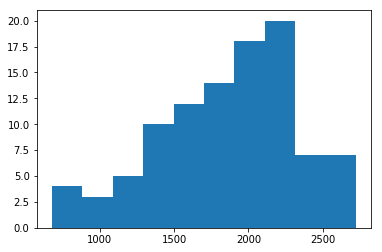

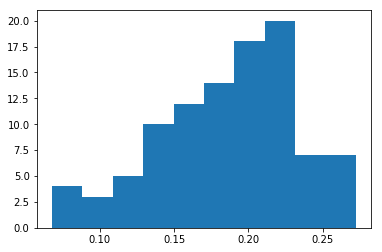

In [20]:
# Metropolis-Hastings with nIter iterations.
accepted  = np.zeros([nSamp, 1], dtype=np.int)
onesV = np.ones([nSamp], dtype=np.int).reshape((-1, 1))
zerosV = np.zeros([nSamp], dtype=np.int).reshape((-1, 1))
for n in range(nIter):
    oldAlpha  = A[-1]  # old parameter value as array
    oldLnLik = lnLik(testSamps.values, oldAlpha, wtSer)
    newAlpha = mutate(oldAlpha, age7DF, stepsizes)
    newLnLik = lnLik(testSamps.values, newAlpha, wtSer)
    if (n % 100 == 0):
        print '%s: %s' % (n, mutualInfo(testSamps.values, newAlpha))
    choices = np.logical_or(newLnLik > oldLnLik,
                            np.random.random(newLnLik.shape) < np.exp(newLnLik - oldLnLik))
    rslt = np.choose(choices, [oldAlpha, newAlpha])
    A.append(rslt)
    accepted += np.choose(choices, [zerosV, onesV])

plt.hist(accepted)
acceptanceRate = accepted/float(nIter)
plt.show()
plt.hist(acceptanceRate)
plt.show()

In [21]:
nKeep = accepted.min()/10  # 10 mutations between samples to avoid correlation
keepStep = nIter//nKeep
burnIn = 10 * keepStep
print nKeep, keepStep, burnIn
assert burnIn < nIter, 'Not enough iterations for burn-in'
clean = []
for idx, sV in enumerate(A[burnIn:]):
    if idx % keepStep == 0:
        clean.append(sV)


67 149 1490


In [22]:
newClean = []
print clean[0].shape
print len(clean)
for sV in clean:
    sV[0] = 14
    newClean.append(sV[:,0:4])
#clean = newClean
print np.concatenate(newClean).shape

print np.concatenate(newClean)


(100, 9)
58
(5800, 4)
[[1.400e+01 1.400e+01 1.400e+01 1.400e+01]
 [2.000e+00 2.000e+00 2.016e+03 4.000e+02]
 [2.000e+00 2.000e+00 2.016e+03 4.000e+02]
 ...
 [2.000e+00 2.000e+00 2.016e+03 1.770e+02]
 [2.000e+00 2.000e+00 2.016e+03 4.000e+02]
 [2.000e+00 2.000e+00 2.016e+03 1.360e+02]]


In [23]:
cleanV = np.concatenate(clean)


In [24]:
expandedTestV = np.repeat(testSamps.values, len(clean), axis=0)
#print expandedTestV
print mutualInfo(expandedTestV, cleanV)
print mutualInfo(expandedTestV, mkSamps(age7DF, cleanV.shape[0]).values)
print mutualInfo(expandedTestV, expandedTestV)
print mutualInfo(cleanV, cleanV)

0.18951005590752787
0.20297485652560024
3.2884672209416523
3.5291158830221514


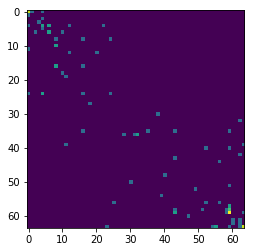

[16 16 16 ... 12 12 12]
[ 8 62 59 ... 22 59 12]


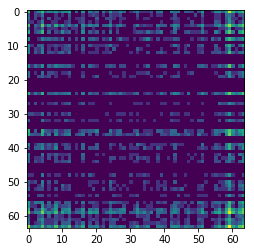

In [25]:
testBins, nBins = whichBin(testSamps.values)
rsltBins = whichBin(clean[0])[0]
hM, xEdges, yEdges = np.histogram2d(testBins, rsltBins, bins=64)
plt.imshow(np.log(hM + 1))
plt.show()
longTestBins = whichBin(expandedTestV)[0]
print longTestBins
longRsltBins = whichBin(cleanV)[0]
print longRsltBins
hM, xEdges, yEdges = np.histogram2d(longTestBins, longRsltBins, bins=64)
plt.imshow(np.log(hM + 1))
plt.show()

## Ignore the rest of this ##
These bits are just left-overs

In [26]:
wtDF = pd.DataFrame({'FPL':[1.0, 1.0], 'SC_AGE_YEARS': [1.0, 1.0], 'K4Q01': [1.0, 1.0], 'K4Q32X01': [1.0, 1.0],
       'K7Q30':[1.0, 1.0], 'K7Q31': [1.0, 1.0], 'AGEPOS4': [1.0, 1.0]}, index=['ACE7', 'ACE8'])
print wtDF

      AGEPOS4  FPL  K4Q01  K4Q32X01  K7Q30  K7Q31  SC_AGE_YEARS
ACE7      1.0  1.0    1.0       1.0    1.0    1.0           1.0
ACE8      1.0  1.0    1.0       1.0    1.0    1.0           1.0


In [27]:
def funV(samps1, samps2, wtDF):
    """
    Returns a numpy matrix the rows of which correspond to ACE7 and ACE8 and
    the columns of which correspond to the input samples
    """
    wtA = wtDF.values
    offset = samps1.values.shape[1] - wtDF.values.shape[1]
    samp1A = samps1.values[:, offset:]
    samp2A = samps2.values[:, offset:]
    delta = samp1A - samp2A
    return np.asmatrix(wtA) * np.asmatrix(delta).transpose()
    

In [28]:
print funV(mkSamps(subDF, 3), mkSamps(subDF, 3), wtDF)

[[  32. -213. -104.]
 [  32. -213. -104.]]


$\mathcal L(\{M_1,M_2,\ldots,M_N\};\alpha) = \prod_{n=1}^N p(M_n|\alpha) = \prod_{n=1}^N c\left(\frac{M_n}{M_\odot}\right)^{-\alpha}$